## Welcome to exercise 03
앞서 배운 것들을 바탕으로 실습을 해봅시다
1) RNN을 LSTM으로 바꿔봅시다 <br>
2) RNN을 ``01_nn_tutorial``을 따라 단계적으로 리팩토링 해봅시다<br>
3) learning curve, embedding을 ``02_Tensorboard``를 따라 tensorboard와 연결해봅시다

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

## Data Loading

In [3]:
def findFiles(path):
    return glob.glob(path)

In [4]:
import unicodedata
import string

In [5]:
all_letters = string.ascii_letters + ",.;'"
n_letters = len(all_letters)

In [6]:
# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters)

In [7]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

In [8]:
# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

## data to Tensor

In [9]:
import torch

In [10]:
# find index of letter
def letterToIndex(letter):
    return all_letters.find(letter)

# 이름(word, line)을 <line_length x 1 x n_letters>로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [11]:
lineToTensor('Jones').shape # 5 -> len('Jones'), 1(batch), 56(len(all_letters))

torch.Size([5, 1, 56])

## Network

In [12]:
from torch import nn

# 1. 네트워크 LSTM으로 바꾸기 

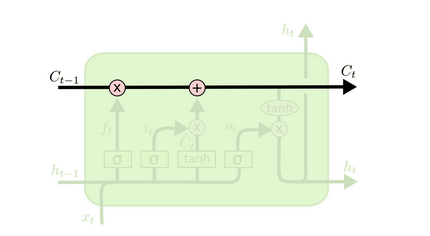

$$ f_t = \sigma(W_f[h_{t-1},x_t]+b_f) $$
$$ i_t = \sigma(W_i[h_{t-1},x_t]+b_i) $$
$$ \tilde{C_t} = tanh(W_c[h_{t-1},x_t]+b_i) $$
$$ C_t = \sigma(f_t * C_{t-1} + i_t * \tilde{C_t}) $$
$$ o_t = \sigma(W_o[h_{t-1}, x_t]+b_o) $$
$$ h_t = tanh(C_t) * o_t $$

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size 
        # nn.Module내의 다른 매개변수는 상속하게 super에서 처리되는데 hidden_size는 없는듯
        '''  define weights '''
        self.i2f = nn.Linear(input_size + hidden_size, hidden_size) # input to forget gate
        self.i2i = nn.Linear(input_size + hidden_size, hidden_size) # input to input gate
        self.i2c = nn.Linear(input_size + hidden_size, hidden_size) # input to cell gate
        self.i2o = nn.Linear(input_size + hidden_size, hidden_size) # input to output gate
        self.h2y = nn.Linear(hidden_size, output_size) # hidden to ouput(prediction)
        
        ''' activation functions '''
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1) 
        # dim = 1 의 의미 : batch 내에서(한데이터셋 묶음 안에서) softmax를 구한다
         
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)       
    
    def forward(self, input, hidden, cell):
        combined = torch.cat((input, hidden), 1)
        # dim = 1 의 의미 : input과 hidden을 옆으로 붙인다
        # input의 shape는 (bacth_size x input_size)
        # hidden의 shape는 (bacth_size x hidden_size)
        # combined의 shape는 (bacth_size x (input_size + hidden_size))가 된다
        
        forget_rate = self.i2f(combined)
        forget_rate = self.sigmoid(forget_rate)
        
        input_rate = self.i2i(combined)
        input_rate = self.sigmoid(input_rate)
        
        cell_tilda = self.i2c(combined)
        cell_tilda = self.tanh(cell_tilda)
        cell = forget_rate * cell + input_rate * cell_tilda 
        
        output_rate = self.i2o(combined)
        output_rate = self.sigmoid(output_rate)
        
        hidden = self.tanh(cell) * output_rate
        
        output = self.h2y(hidden)
        output = self.softmax(output)
        return output, hidden, cell
 

## model instance test

### model parameter 

In [14]:
n_hidden = 128
learning_rate = 0.005
batch_size = 1
input_size = n_letters
output_size = n_categories
epochs = 1
criterion = nn.NLLLoss()
torch.device('cuda')

device(type='cuda')

In [16]:
torch.cuda.is_available()

True

In [17]:
rnn = LSTM(n_letters, n_hidden, n_categories)
input = lineToTensor('Albert')
hidden = torch.zeros(batch_size, n_hidden) # initial hidden statate as zero vector
cell = torch.zeros(batch_size, n_hidden) # initial hidden statate as zero vector
output, next_hidden, next_cell = rnn(input[0], hidden, cell)
output

tensor([[-2.8655, -2.9868, -2.8198, -2.8357, -2.8852, -2.9424, -2.9659, -2.8584,
         -2.8623, -2.9773, -2.8759, -2.8441, -2.9532, -2.8131, -2.8143, -2.8806,
         -2.9167, -2.9592]], grad_fn=<LogSoftmaxBackward>)

## prepare for train

In [18]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 13)


In [19]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Nakamoto
category = Portuguese / line = Ventura
category = Chinese / line = Tian
category = Dutch / line = Schuyler
category = Russian / line = Kabirov
category = French / line = Deniel
category = Vietnamese / line = Quang
category = French / line = Samson
category = French / line = Charpentier
category = Arabic / line = Abadi


## train network 

In [20]:
def train(category_tensor, line_tensor):
    # 한 배치에 대한 train 코드
    hidden = rnn.initHidden() # hidden layer 초기화
    cell = rnn.initHidden() # cell layer 초기화

    rnn.zero_grad() # gradient 초기화

    for i in range(line_tensor.size()[0]): # 글자마다 
        output, hidden, cell = rnn(line_tensor[i], hidden, cell) 
        # 글자마다 output은 나오는데 for문에서는 hidden만 사용되고
    
    # for 문이 끝나면 output이 평가됨
    criterion = nn.NLLLoss()
    loss = criterion(output, category_tensor)
    loss.backward() # 역전파 진행

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss

In [22]:
import math
import time

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 18s) 2.9318 Ma / Spanish ✗ (Korean)
10000 10% (0m 36s) 2.8909 Gouveia / Czech ✗ (Portuguese)
15000 15% (0m 54s) 2.7665 Esparza / Portuguese ✗ (Spanish)
20000 20% (1m 13s) 2.8961 Xin / Scottish ✗ (Chinese)
25000 25% (1m 31s) 2.6562 Tell / English ✓
30000 30% (1m 49s) 1.5701 Moraitopoulos / Greek ✓
35000 35% (2m 8s) 2.6300 Pelletier / Greek ✗ (French)
40000 40% (2m 27s) 2.5101 Gordon / Irish ✗ (Scottish)
45000 45% (2m 45s) 2.1590 Charpentier / German ✗ (French)
50000 50% (3m 3s) 1.5329 Ekiguchi / Japanese ✓
55000 55% (3m 22s) 3.2853 Sandoval / Russian ✗ (Spanish)
60000 60% (3m 40s) 1.2176 La / Vietnamese ✓
65000 65% (3m 58s) 1.1721 Gong / Korean ✗ (Chinese)
70000 70% (4m 17s) 3.6818 Arbore / French ✗ (Italian)
75000 75% (4m 35s) 0.1283 Kyritsis / Greek ✓
80000 80% (4m 53s) 1.7244 Kang / Chinese ✗ (Korean)
85000 85% (5m 11s) 1.7140 Niall / Irish ✓
90000 90% (5m 30s) 1.2016 Santos / Greek ✗ (Portuguese)
95000 95% (5m 48s) 3.1518 Uerling / French ✗ (Czech)
100000 100% (6m 7s) 0.

## learning curve

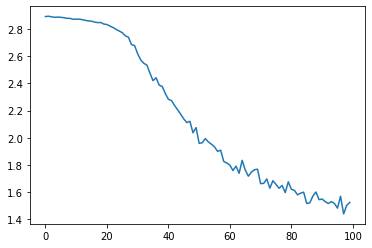

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## evaluation ( metrics )  

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


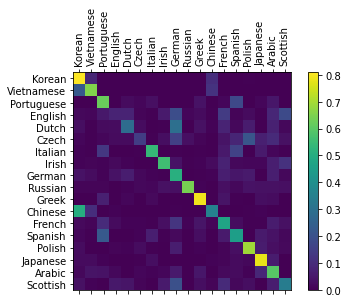

In [24]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    cell = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden, cell = rnn(line_tensor[i], hidden, cell)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# 2. refactoring 

TensorDataset에 넣기 위해서 train, test 셋을 나누고, 캐릭터를 원핫인코딩하여 텐서로 바꾸고 나라 카테고리를 숫자로 바꾸는 전처리가 필요함<br>
그래서 이와 같은 과정을 한번에 할 수 있는 사용자 Dataset을 정의하는 것이 효율적으로 보임

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch.utils.data import Dataset

In [27]:
le = preprocessing.LabelEncoder()
le = le.fit(all_categories)

In [28]:
x = []
y = []
for key, value in category_lines.items():
    for v in value:
        x.append(v)
        y.append(key)

In [29]:
train_x, test_x, train_y, test_y = train_test_split(x, y)

## 1) 사용자 DataSet 작성하기
https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html<br>

``torch.utils.data.Dataset``은 데이터셋을 나타내는 추상클래스입니다. 여러분의 데이터셋은 ``Dataset``에 상속하고 아래와 같이 오버라이드 해야합니다.
- len(dataset) 에서 호출되는 \__len__ 은 데이터셋의 크기를 리턴해야합니다.
- dataset[i] 에서 호출되는 \__getitem__ 은 i번째 샘플을 찾는데 사용됩니다.

### 간단 실습
들어가기 전에 \__len__ 와 \__getitem__에 대하여 실습해보자<br>
무슨 리스트를 넣어도 len() 함수를 넣으면 길이가 4라고 출력하고<br>
몇을 인덱싱해도 [4,4,4,4]라고 하는 자료형을 만들어보자 

In [30]:
class must_be_4_list(list):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return 4
    def __getitem__(self, idx):
        return [4,4,4,4]

In [31]:
must4 = must_be_4_list(['I am string'])
must4.data

['I am string']

In [32]:
len(must4)

4

In [33]:
must4[0]

[4, 4, 4, 4]

In [34]:
from torch.utils.data import Dataset

In [35]:
class NameDataset(Dataset):
    def __init__(self, data_x, data_y, transform_x=None, transform_y=None):
        self.data_x = data_x
        self.data_y = data_y
        self.transform_x = transform_x
        self.transform_y = transform_y
        if transform_y: # y에 대한 전처리 과정이 있으면, label encoder를 생성한다
            le = preprocessing.LabelEncoder()
            self.le = le.fit(data_y)
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        sample_x = self.data_x[idx]
        sample_y = self.data_y[idx]
        if self.transform_x: # x에 대한 전처리
            sample_x = self.transform_x(sample_x)
            sample_x = torch.Tensor(sample_x)
        if self.transform_y: # y에 대한 전처리
            sample_y = self.transform_y(sample_y, self.le)
        return sample_x, sample_y

In [36]:
from torch.utils.data import DataLoader

In [37]:
def labelEncoding(data, le):
    data = np.array([data])
    return le.transform(data)

In [38]:
train_ds = NameDataset(train_x, train_y, 
                       transform_x=lineToTensor, transform_y=labelEncoding)
test_ds = NameDataset(test_x, test_y, 
                       transform_x=lineToTensor, transform_y=labelEncoding)

## 2) DataLoader 정의하기

In [39]:
# transform_x에서 batch 묶는 것까지 해줬기 때문에 DataLoader에선 batch_size를 주지 않는다
train_dl = DataLoader(train_ds, batch_size=None) 
test_dl = DataLoader(train_ds, batch_size=None)

In [40]:
for x, y in train_dl:
    print(x.shape)
    print(y.dtype)
    break

torch.Size([10, 1, 56])
torch.int64


In [41]:
train_dl, test_dl

(<torch.utils.data.dataloader.DataLoader at 0x7f71dde8aa58>,
 <torch.utils.data.dataloader.DataLoader at 0x7f71dde8acf8>)

## 3) optim 정의하기 

In [80]:
from torch import optim

In [81]:
def get_model():
    model = LSTM(input_size, n_hidden, output_size)
    return model, optim.SGD(model.parameters(), lr=learning_rate)

In [82]:
def train(line_tensor, category_tensor):
    # 한 배치에 대한 train 코드
    model, optim = get_model()
    hidden = rnn.initHidden() # hidden layer 초기화
    cell = rnn.initHidden() # cell layer 초기화

    
    rnn.zero_grad() # gradient 초기화

    for i in range(line_tensor.size()[0]): # 글자마다 
        output, hidden, cell = rnn(line_tensor[i], hidden, cell) 
        # 글자마다 output은 나오는데 for문에서는 hidden만 사용되고
    
    # for 문이 끝나면 output이 평가됨
    loss = criterion(output, category_tensor)
    loss.backward() # 역전파 진행
    optim.step()
    optim.zero_grad()
    return output, loss

In [83]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),TensorDataset에
    )

In [75]:
for xb, yb in train_dl:
    output, loss = train(xb, yb)

KeyboardInterrupt: 

# 3. Tensorboard

In [84]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/where_is_the_name_from')

### 모델 그래프 

In [85]:
model, optimizer = get_model()

In [77]:
# writer.add_graph(model, xb[0])
# NN의 forward에는 hidden과 cell에 대한 부분이 없고 training에서 이를 진행함 어떻게 해결해야하지?

### confusion matrix 

In [78]:
writer.add_figure('confusion matrix', fig)

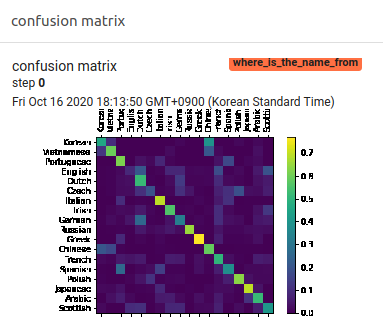

### learning curve 

In [91]:
running_loss = 0.0
i = 0
for xb, yb in train_dl:
    output, loss = train(xb, yb)
    running_loss += loss 
    if i % 1000 == 0:
        writer.add_scalar('training loss', running_loss/1000, i)
        print('epoch {} loss {}'.format(i, running_loss/1000))
        running_loss = 0.0
    i += 1

epoch 0 loss 0.00713481055572629
epoch 1000 loss 4.548728942871094
epoch 2000 loss 4.532883167266846
epoch 3000 loss 4.6557416915893555
epoch 4000 loss 4.536654472351074
epoch 5000 loss 4.571136951446533
epoch 6000 loss 4.402733325958252
epoch 7000 loss 4.619790554046631
epoch 8000 loss 4.43898868560791
epoch 9000 loss 4.528797149658203
epoch 10000 loss 4.486570835113525
epoch 11000 loss 4.473449230194092
epoch 12000 loss 4.42062520980835
epoch 13000 loss 4.449978351593018
epoch 14000 loss 4.473233222961426
epoch 15000 loss 4.493645191192627
